In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0005472336590786565
1d Y error =  0.00038736877123649244


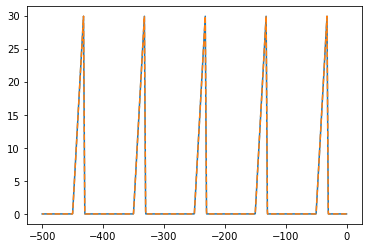

In [3]:
L_x, L_p, x2, x3, h = 500, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


[785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
sample =  785.0
min loss =  262913.0332581358 L_p, x2, x3, h =  tensor(62.8751) tensor(-8.6999) tensor(-15.8551) tensor(28.0102)
predicted loss:  254397.64995470608
8515.383303429742
0.24987506246876562


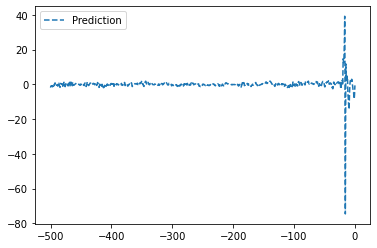

In [4]:
# All data design results
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:, 0:n_data]
inputY_raw = np.load(INPUT_Y)[:, 0:n_data]
inputPara_raw = np.load(INPUT_para)[:, 0:n_data]
output_raw = np.load(OUTPUT)[:, 0:n_data]


# nx ny
L_x , N_s = 500.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d500", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = model(X_Y).squeeze().detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="Prediction")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
gradient =  None
0 0.020482627674937248 loss =  545733.0625
L_p, x1, x2, x3, h  =  100.0 -50.0 -30.0 -30.0 25.0


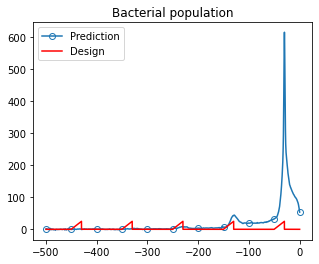

gradient =  tensor([-88114656.0000,  -8712598.0000,  -7028161.0000,    507348.2188])
200 0.015546418726444244 loss =  479514.875
L_p, x1, x2, x3, h  =  91.5901107788086 -45.7950553894043 -30.532968521118164 -27.399295806884766 25.3314151763916


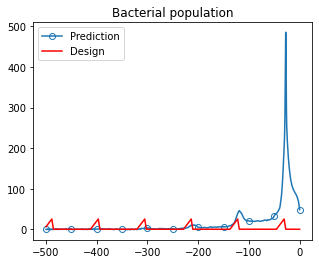

gradient =  tensor([-99282448.0000, -13739306.0000,  -9960605.0000,   2725079.5000])
400 0.015491893514990807 loss =  465461.03125
L_p, x1, x2, x3, h  =  84.97435760498047 -42.487178802490234 -31.020713806152344 -25.221973419189453 26.31473159790039


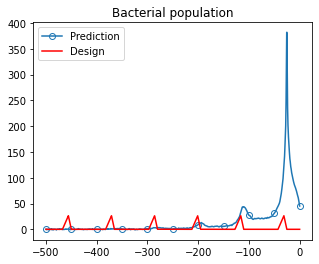

gradient =  tensor([-1.0954e+08, -1.8708e+07, -1.1734e+07,  4.6725e+06])
600 0.015243727713823318 loss =  448773.6875
L_p, x1, x2, x3, h  =  79.69244384765625 -39.846221923828125 -31.217254638671875 -23.3426513671875 27.08614730834961


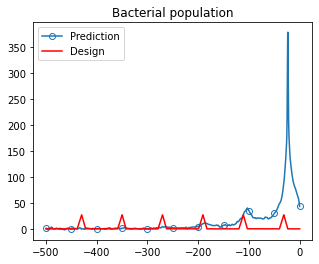

gradient =  tensor([-1.4227e+08, -2.3338e+07, -1.3005e+07,  7.9454e+06])
800 0.01547992043197155 loss =  392604.21875
L_p, x1, x2, x3, h  =  75.57962799072266 -37.78981399536133 -31.429790496826172 -21.800317764282227 27.794567108154297


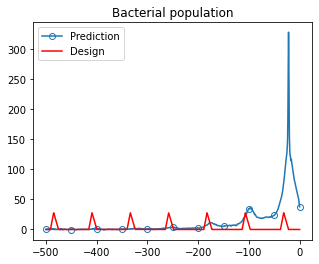

gradient =  tensor([-1.4652e+08, -2.8412e+07, -1.4337e+07,  9.7628e+06])
1000 0.015554983168840408 loss =  377301.46875
L_p, x1, x2, x3, h  =  72.29692840576172 -36.14846420288086 -31.528705596923828 -20.50623893737793 28.32843780517578


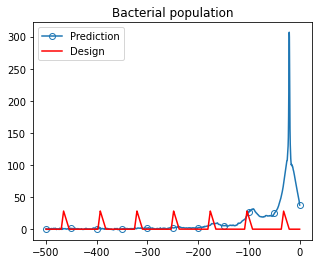

gradient =  tensor([-1.4790e+08, -3.3303e+07, -1.5580e+07,  1.0439e+07])
1200 0.015965793281793594 loss =  372127.375
L_p, x1, x2, x3, h  =  69.73497772216797 -34.867488861083984 -31.533611297607422 -19.452903747558594 28.709178924560547


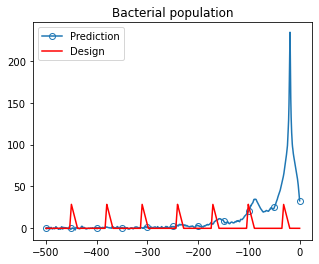

gradient =  tensor([-1.5790e+08, -3.6079e+07, -1.6207e+07,  1.0819e+07])
1400 0.015907946974039078 loss =  360774.8125
L_p, x1, x2, x3, h  =  67.73519897460938 -33.86759948730469 -31.450836181640625 -18.600351333618164 28.982576370239258


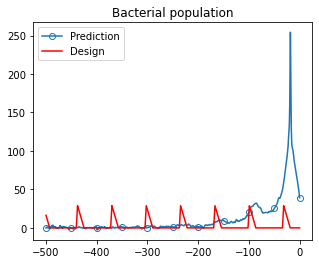

gradient =  tensor([-1.6374e+08, -3.8022e+07, -1.6522e+07,  1.1364e+07])
1600 0.015490870922803879 loss =  351644.75
L_p, x1, x2, x3, h  =  66.1824951171875 -33.09124755859375 -31.32428550720215 -17.91794776916504 29.197330474853516


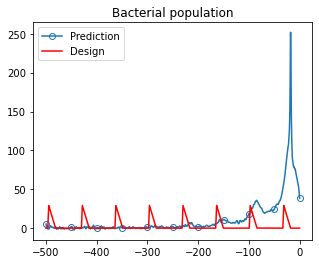

gradient =  tensor([-1.4842e+08, -3.8977e+07, -1.6729e+07,  1.0997e+07])
1800 0.015400901436805725 loss =  368783.71875
L_p, x1, x2, x3, h  =  64.97405242919922 -32.48702621459961 -31.172401428222656 -17.373741149902344 29.35833740234375


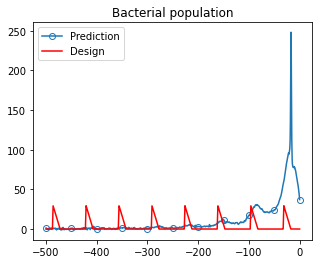

gradient =  tensor([-1.3768e+08, -3.9931e+07, -1.6865e+07,  1.0732e+07])
2000 0.015501121059060097 loss =  379808.59375
L_p, x1, x2, x3, h  =  64.1036148071289 -32.05180740356445 -31.07984161376953 -16.975807189941406 29.480878829956055


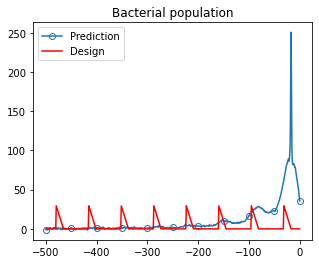

gradient =  tensor([-1.3435e+08, -4.0493e+07, -1.6922e+07,  1.0561e+07])
2200 0.01540055125951767 loss =  383136.875
L_p, x1, x2, x3, h  =  63.40345001220703 -31.701725006103516 -30.980548858642578 -16.65040397644043 29.576946258544922


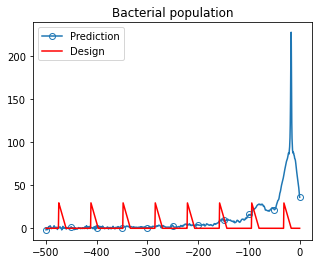

gradient =  tensor([-1.3308e+08, -4.0832e+07, -1.6934e+07,  1.0539e+07])
2400 0.015719296410679817 loss =  383677.28125
L_p, x1, x2, x3, h  =  62.82559585571289 -31.412797927856445 -30.874422073364258 -16.378063201904297 29.654300689697266


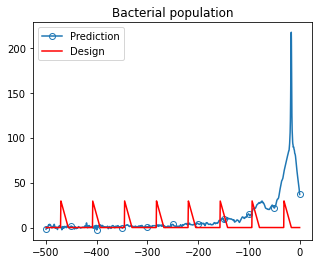

gradient =  tensor([-1.3251e+08, -4.1099e+07, -1.6937e+07,  1.0578e+07])
2600 0.015354763716459274 loss =  382793.125
L_p, x1, x2, x3, h  =  62.34148025512695 -31.170740127563477 -30.765199661254883 -16.147249221801758 29.717405319213867


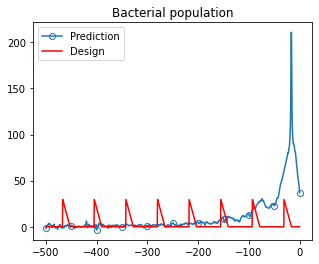

gradient =  tensor([-1.3363e+08, -4.1323e+07, -1.6938e+07,  1.0638e+07])
2800 0.01571520045399666 loss =  380088.625
L_p, x1, x2, x3, h  =  61.93582534790039 -30.967912673950195 -30.659658432006836 -15.95205020904541 29.769081115722656


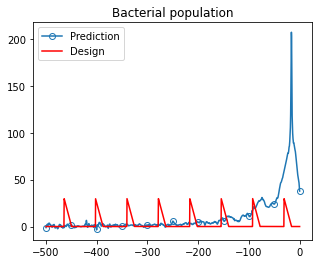

gradient =  tensor([-1.3369e+08, -4.1546e+07, -1.6939e+07,  1.0731e+07])
3000 0.015471555292606354 loss =  378354.53125
L_p, x1, x2, x3, h  =  61.59560012817383 -30.797800064086914 -30.561141967773438 -15.787115097045898 29.81147003173828


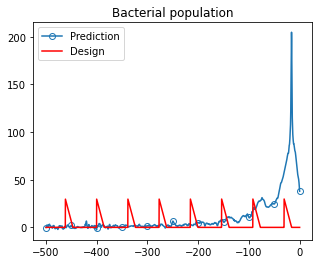

gradient =  tensor([-1.3132e+08, -4.1762e+07, -1.6942e+07,  1.0821e+07])
3200 0.015245653688907623 loss =  379248.71875
L_p, x1, x2, x3, h  =  61.3158073425293 -30.65790367126465 -30.47549057006836 -15.650699615478516 29.846229553222656


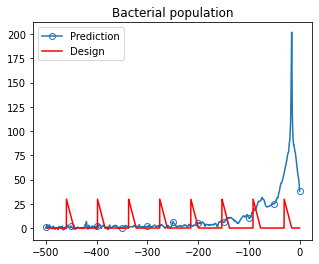

gradient =  tensor([-1.2939e+08, -4.1928e+07, -1.6943e+07,  1.0889e+07])
3400 0.015234848484396935 loss =  380072.40625
L_p, x1, x2, x3, h  =  61.08696365356445 -30.543481826782227 -30.402753829956055 -15.538615226745605 29.874650955200195


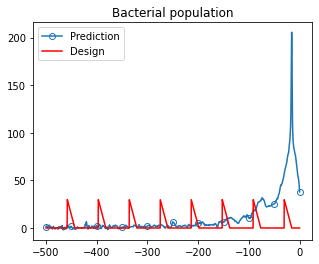

gradient =  tensor([-1.2852e+08, -4.2036e+07, -1.6944e+07,  1.0936e+07])
3600 0.015396744012832642 loss =  380136.40625
L_p, x1, x2, x3, h  =  60.89820861816406 -30.44910430908203 -30.340227127075195 -15.44581413269043 29.897830963134766


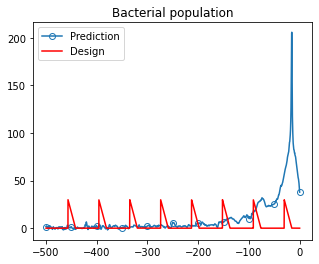

gradient =  tensor([-1.2845e+08, -4.2101e+07, -1.6944e+07,  1.0964e+07])
3800 0.015232902020215988 loss =  379654.5625
L_p, x1, x2, x3, h  =  60.74147033691406 -30.37073516845703 -30.286035537719727 -15.368513107299805 29.916702270507812


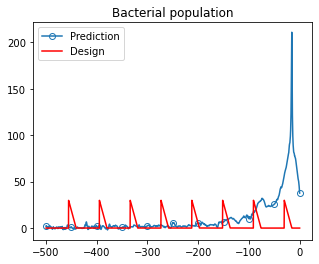

gradient =  tensor([-1.2875e+08, -4.2148e+07, -1.6943e+07,  1.0984e+07])
4000 0.015836583450436592 loss =  378885.375
L_p, x1, x2, x3, h  =  60.61110305786133 -30.305551528930664 -30.23920249938965 -15.30405330657959 29.93206024169922


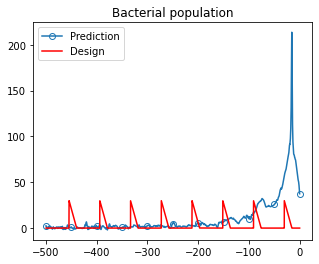

gradient =  tensor([-1.2948e+08, -4.2180e+07, -1.6943e+07,  1.0995e+07])
4200 0.015607619658112526 loss =  377787.625
L_p, x1, x2, x3, h  =  60.50275421142578 -30.25137710571289 -30.19901466369629 -15.250368118286133 29.944561004638672


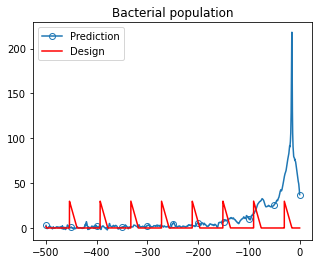

gradient =  tensor([-1.3089e+08, -4.2198e+07, -1.6942e+07,  1.1004e+07])
4400 0.015420550480484962 loss =  376098.34375
L_p, x1, x2, x3, h  =  60.41263961791992 -30.20631980895996 -30.164621353149414 -15.205641746520996 29.95473861694336


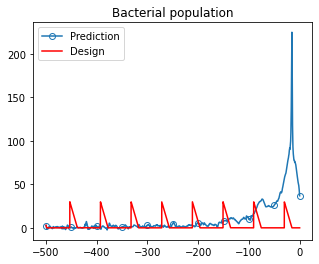

gradient =  tensor([-1.3258e+08, -4.2207e+07, -1.6942e+07,  1.1013e+07])
4600 0.015538457781076431 loss =  374153.53125
L_p, x1, x2, x3, h  =  60.33778381347656 -30.16889190673828 -30.135358810424805 -15.168437957763672 29.96303367614746


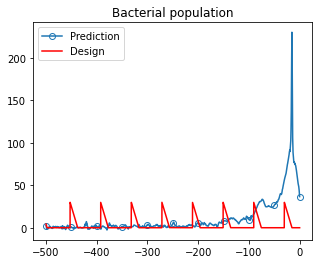

gradient =  tensor([-1.3419e+08, -4.2210e+07, -1.6942e+07,  1.1022e+07])
4800 0.016245165839791298 loss =  372301.59375
L_p, x1, x2, x3, h  =  60.27592468261719 -30.137962341308594 -30.11076545715332 -15.137659072875977 29.969799041748047


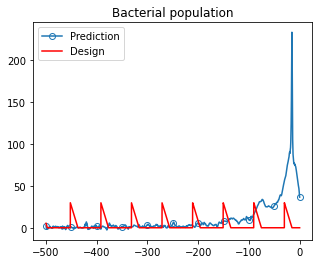

gradient =  tensor([-1.3586e+08, -4.2208e+07, -1.6941e+07,  1.1029e+07])
5000 0.015694836154580116 loss =  370407.53125
L_p, x1, x2, x3, h  =  60.224971771240234 -30.112485885620117 -30.09026336669922 -15.112283706665039 29.975318908691406


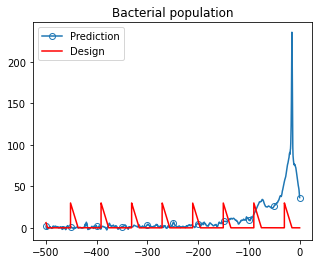

In [26]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))

learning_rate = 0.001
epochs = 5001
step_size = 1000
gamma = 1.0

# learning_rate = 0.001
# epochs = 5001
# step_size = 500
# gamma = 0.5

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
# def transfer(theta):
    
#     L_p = 60 + (250 - 60)/(1 + torch.abs(theta[0]))
#     x1 = -0.5*L_p
#     x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
#     x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
#     h = 20   + (10)/(1 + torch.abs(theta[3]))
#     return L_p, x1, x2, x3, h

# def inv_transfer(L_p, x2, x3, h):
#     x1 = -0.5*L_p
#     theta = np.zeros(4)
#     theta[0] = (250 - 60)/(L_p - 60) - 1
#     theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
#     theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
#     theta[3] = 10/(h - 20 ) - 1
#     return theta


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/4
#.          -L_p/4 < x2 - x3 < L_p/4
#               20 < h < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.exp(theta[2]))
    x2 = x3  - L_p/4 + (L_p/2)/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( (L_p/2)/(x2 - x3  + L_p/4) - 1 )
    theta[2] = np.log( (L_p/4 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -30.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -15.0, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =    inv_transfer(L_p, x2, x3, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
#     out = torch.clip(model(x).squeeze(), min=0.0)
    # out = torch.clip(model(x).squeeze(), min=0.0)
    out = model(x).squeeze()
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    if ep%200==0:
        print("gradient = ", theta.grad)
        
    loss.backward()
    
        
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
        
        
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

In [21]:
################################################################
# inverse optimization for 1d
################################################################



L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
# learning_rate = 0.001
# epochs = 5001
# step_size = 500
# gamma = 0.5

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x3 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30

loss_min = np.inf
L_p_min, x2_min, x3_min = np.NaN, np.NaN, np.NaN
mesh_min = np.NaN
density_min = np.NaN
nLp = 190
for L_p in np.linspace(60, 80, 20+1):
    print("L_p = ", L_p)
    x1 = -L_p/2
    for dx3_x1 in np.linspace(15, L_p/2, np.int64(np.round((L_p/2 - 15)))+1):
        print("dx3_x1 = ", dx3_x1)
        x3 = x1 + dx3_x1
        for h in np.linspace(25, 30, 6):
            for x2 in np.linspace(-L_p, 0, np.int64(np.round(L_p))+1):
            
                
                XC, YC = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
                x = torch.tensor(np.vstack((XC,YC)).transpose()[np.newaxis, : ,:], dtype=torch.float).to(device) 
                
#                 L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
#                 xx, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
#                 print(x - xx)
                out = model(x).squeeze()
                loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
                if loss < loss_min:
                    L_p_min, x2_min, x3_min, h_min = L_p, x2, x3, h
                    mesh_min = np.copy(x.detach().cpu().numpy())
                    density_min = np.copy(out.detach().cpu().numpy())
                    loss_min = loss
                    print(L_p_min, x2_min, x3_min, h_min, loss_min)
                
plt.figure(figsize=(5,4))
plt.title("Bacterial population")
plt.plot(xx_mask.detach().cpu().numpy(), density_min, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
plt.plot(mesh_min[0, :, 0], mesh_min[0, :, 1], color="r", label="Design")

plt.legend()
plt.show()



L_p =  60.0
dx3_x1 =  15.0
60.0 -60.0 -15.0 25.0 tensor(1163177.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 26.0 tensor(1146735.1250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 27.0 tensor(1127114.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 28.0 tensor(1108573.5000, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 29.0 tensor(1086953.7500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -60.0 -15.0 30.0 tensor(1062519.3750, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -59.0 -15.0 30.0 tensor(1058539.2500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -58.0 -15.0 30.0 tensor(1051428.2500, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -57.0 -15.0 30.0 tensor(1041059.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -56.0 -15.0 30.0 tensor(1029130.6250, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -55.0 -15.0 30.0 tensor(1016953.6875, device='cuda:0', grad_fn=<DivBackward0>)
60.0 -54.0 -15.0 30.0 tensor(1005137.5625, device

KeyboardInterrupt: 